## Example of QCing a Xenium sample

This example was based on Elina and Koen's work.

__created__ = "2024-10-28 Mon 16:48:30 GMT"

__updated__ = "2024-11-05"

__version__ = "0.0.9"

__status__ = "Prototype"

__license__ = "GPL"

__maintainer__ = "Ciro Ramírez-Suástegui"

__author__ = "Ciro Ramírez-Suástegui"

__email__ = "cs59@sanger.ac.uk, cramsuig@gmail.com"

#### Structure <a class="anchor" id="menu"></a>

* [Global variables and paths](#bullet1)
* [Loading data](#bullet2)
* [Pre-processing](#bullet3)
* [Main](#bullet4)
* [Conclusions](#bullet5)
* [Save](#bullet6)

### Environment setup

#### Jupyter extensions

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

#### Basic modules

In [2]:
import os, sys, warnings, re, time
import inspect, pickle

#### Logging configuration

In [3]:
import logging, datetime

In [4]:
logging.basicConfig(
    format="[%(asctime)s] %(levelname)-2s [%(filename)s:%(lineno)s] %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
    stream=sys.stdout,  # send to output (no red background)
)
logging.addLevelName(
    logging.INFO, "\033[1;32m%s\033[1;0m" % logging.getLevelName(logging.INFO)
)

In [5]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

#### Working path

In [6]:
try:
    __file__
except NameError:
    logging.info("Based on current directory")
    __file__ = os.path.abspath("")  # pathlib.Path().cwd()

[2024-11-05 09:54:25] INFO [687866085.py:4] Based on current directory


In [7]:
project_path = os.path.dirname(os.path.realpath(__file__))
if os.path.basename(project_path) != os.path.basename(os.getcwd()):
    os.chdir(project_path)

In [8]:
# show current environment and path
# fmt: off
bpaths = ".*" + os.environ.get('USER', os.environ.get('USERNAME')) + "|.os.py|.*mamba|.*conda"
logging.info(f'Environment: {re.sub(bpaths, "", os.__file__)}')
logging.info(f'Working at: {re.sub(bpaths, "", os.getcwd())}'); del bpaths
# fmt: on

[2024-11-05 09:54:49] INFO [309871470.py:4] Environment: forge/envs/squidpy_v1.4.1/lib/python3.10
[2024-11-05 09:54:49] INFO [309871470.py:5] Working at: /CTCLv2


In [9]:
!echo -e "[$(date '+%Y-%m-%d %T')] \033[1;32mINFO\033[0m [${0##*/}:${FUNCNAME}:${LINENO}] :: Machine: ${HOSTNAME}"

[2024-11-05 09:55:17] INFO [bash::1] :: Machine: node-13-21


#### In-house/developing modules

In [10]:
sys_path_add = ["code/"]
[sys.path.append(i) for i in sys_path_add if i not in sys.path]
# import filename as shortname

[None]

#### Tool (packaged) modules

In [11]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.figure as mplfig  # to check for Figure type

In [12]:
import anndata as ad
import scipy.sparse as sp
import seaborn as sns
import squidpy as sq

### [Global variables and paths](#menu) <a class="anchor" id="bullet1"></a>

In [14]:
indata_name = "example_1"
action_name = "qc"
result_name = f"{action_name}_{indata_name}"

In [15]:
inputs_path = "./data"
inputs_edat = "/nfs/team283/ej10/GBM_Xenium_Samples/sample_1/cell_feature_matrix.h5"
inputs_mdat = "/nfs/team283/ej10/GBM_Xenium_Samples/sample_1/cells.csv.gz"

In [16]:
output_resu = os.path.join("./results", f"{result_name}")
output_figs = os.path.join("./figures", f"{result_name}")
output_name = indata_name
output_file = os.path.join(inputs_path, f"{output_name}_{action_name}.h5ad")

In [17]:
OUTPUTS = dict()

In [18]:
%whos str dict

Variable       Type    Data/Info
--------------------------------
OUTPUTS        dict    n=0
action_name    str     qc
indata_name    str     example_1
inputs_edat    str     /nfs/team283/ej10/GBM_Xen<...>_1/cell_feature_matrix.h5
inputs_mdat    str     /nfs/team283/ej10/GBM_Xen<...>les/sample_1/cells.csv.gz
inputs_path    str     ./data
output_figs    str     ./figures/qc_example_1
output_file    str     ./data/example_1_qc.h5ad
output_name    str     example_1
output_resu    str     ./results/qc_example_1
project_path   str     /lustre/scratch126/cellgen/team298/cs59/CTCLv2
result_name    str     qc_example_1


#### Visualisation parameters

In [19]:
# https://github.com/scverse/scanpy/blob/be99b230fa84e077f5167979bc9f6dacc4ad0d41/src/scanpy/plotting/_rcmod.py#L12
# https://github.com/scverse/scanpy/blob/a91bb02b31a637caeee77c71dcd9fbce8437cb7d/src/scanpy/_settings.py#L419-L509
rcParams_dict = {
    "figure.figsize": (4, 4),  # scanpy:4x4
    "figure.dpi": 80,  # scanpy:80
    "figure.frameon": False,
    "grid.linestyle": "dotted",
    "grid.color": "#f2f2f2",
    "font.size": 10,  # scanpy:14
    # https://matplotlib.org/stable/users/explain/colors/colormaps.html
    "image.cmap": "viridis",
    "lines.markersize": 2,  # dotplot size
    "savefig.dpi": 150,  # default is 'figure', scanpy:150
    "savefig.bbox": "tight",
    "savefig.transparent": True,
}

#### Scanpy settings and logging

In [20]:
sc.logging.print_versions()

-----
anndata     0.10.8
scanpy      1.10.1
-----
30fcd23745efe32ce681__mypyc NA
PIL                         10.0.0
asciitree                   NA
asttokens                   NA
attr                        23.2.0
black                       24.10.0
blib2to3                    NA
brotli                      1.1.0
certifi                     2024.06.02
charset_normalizer          3.3.2
click                       8.1.7
cloudpickle                 3.0.0
colorama                    0.4.6
comm                        0.2.2
cycler                      0.12.1
cython_runtime              NA
cytoolz                     0.12.3
dask                        2024.6.2
dask_expr                   1.1.5
dask_image                  NA
datashader                  0.16.2
datatree                    0.0.14
dateutil                    2.9.0
debugpy                     1.8.1
decorator                   5.1.1
docrep                      0.3.2
exceptiongroup              1.2.0
executing                   2.0.1


In [21]:
sc.settings.set_figure_params(dpi_save=rcParams_dict["savefig.dpi"])
sc.settings.set_figure_params(
    **{
        re.sub("figure|\.", "", k): rcParams_dict[k]
        for k in rcParams_dict.keys()
        if re.match("figure|font", k)
    }
)
sc.settings.figdir = output_figs

In [22]:
# plt.style.available or path (.config/rparams_analysis.mplstyle)
plt.style.use("seaborn-v0_8-colorblind")
rcmax = max([len(i) for i in list(rcParams_dict.keys())])
for i in rcParams_dict.keys():
    i_def = "def:" + str(plt.rcParamsDefault[i]).rjust(10, " ")
    i_new = str(plt.rcParams[i]).rjust(10, " ")
    temp = " ".join([i.ljust(rcmax, " "), i_def, "|", i_new, ">"])
    plt.rcParams[i] = rcParams_dict[i]
    temp = " ".join([temp, str(plt.rcParams[i])])
    logging.info(temp)

[2024-11-05 09:57:11] INFO [2465736609.py:10] figure.figsize      def:[6.4, 4.8] | [4.0, 4.0] > [4.0, 4.0]
[2024-11-05 09:57:11] INFO [2465736609.py:10] figure.dpi          def:     100.0 |       80.0 > 80.0
[2024-11-05 09:57:11] INFO [2465736609.py:10] figure.frameon      def:      True |       True > False
[2024-11-05 09:57:11] INFO [2465736609.py:10] grid.linestyle      def:         - |          - > dotted
[2024-11-05 09:57:11] INFO [2465736609.py:10] grid.color          def:   #b0b0b0 |         .8 > #f2f2f2
[2024-11-05 09:57:11] INFO [2465736609.py:10] font.size           def:      10.0 |       10.0 > 10.0
[2024-11-05 09:57:11] INFO [2465736609.py:10] image.cmap          def:   viridis |    viridis > viridis
[2024-11-05 09:57:11] INFO [2465736609.py:10] lines.markersize    def:       6.0 |        6.0 > 2.0
[2024-11-05 09:57:11] INFO [2465736609.py:10] savefig.dpi         def:    figure |      150.0 > 150.0
[2024-11-05 09:57:11] INFO [2465736609.py:10] savefig.bbox        def:      

### [Loading data](#menu) <a class="anchor" id="bullet2"></a>

In [25]:
adata = sc.read_10x_h5(inputs_edat)

In [26]:
adata

AnnData object with n_obs × n_vars = 267766 × 5001
    var: 'gene_ids', 'feature_types', 'genome'

In [27]:
metadata = pd.read_csv(inputs_mdat)

In [28]:
metadata

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method
0,aaabfdma-1,476.929749,2833.977539,18,0,0,0,0,0,18,37.253908,25.964845,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
1,aaabjadb-1,518.825928,2502.397461,1891,0,0,0,0,11,1902,89.680316,64.076721,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
2,aaablimp-1,473.026886,2476.340820,1027,0,0,0,0,1,1028,85.300159,56.174377,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
3,aaabmbjg-1,481.827423,3274.943115,24,0,0,0,0,0,24,67.508596,18.423751,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
4,aaabpeno-1,480.916626,3267.390381,15,0,0,0,0,0,15,118.444848,NaN,0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
267761,oiobhkcb-1,7158.467773,14559.524414,30,0,0,0,0,0,30,5.238125,5.238125,1,Segmented by nucleus expansion of 5.0µm
267762,oiobidpk-1,7263.129883,14583.701172,593,0,0,0,0,0,593,51.252346,51.252346,1,Segmented by nucleus expansion of 5.0µm
267763,oioblbmh-1,7276.387695,14943.915039,1182,0,0,0,0,17,1199,77.262347,52.065158,1,Segmented by nucleus expansion of 5.0µm
267764,oiobplmc-1,7277.247070,14745.753906,1005,0,0,0,0,16,1021,179.812194,25.964845,1,Segmented by nucleus expansion of 5.0µm


### [Pre-processing](#menu) <a class="anchor" id="bullet3"></a>

In [29]:
metadata.set_index(adata.obs_names, inplace=True)
adata.obs = metadata.copy()

In [30]:
adata.obs.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,genomic_control_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,nucleus_count,segmentation_method
aaabfdma-1,aaabfdma-1,476.929749,2833.977539,18,0,0,0,0,0,18,37.253908,25.964845,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaabjadb-1,aaabjadb-1,518.825928,2502.397461,1891,0,0,0,0,11,1902,89.680316,64.076721,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaablimp-1,aaablimp-1,473.026886,2476.340820,1027,0,0,0,0,1,1028,85.300159,56.174377,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaabmbjg-1,aaabmbjg-1,481.827423,3274.943115,24,0,0,0,0,0,24,67.508596,18.423751,1,Segmented by boundary stain (ATP1A1+CD45+E-Cad...
aaabpeno-1,aaabpeno-1,480.916626,3267.390381,15,0,0,0,0,0,15,118.444848,NaN,0,Segmented by boundary stain (ATP1A1+CD45+E-Cad...


In [31]:
del metadata

### [Main](#menu) <a class="anchor" id="bullet4"></a>

#### Perform basic QC analysis á la Squidpy

In [32]:
%%time
sc.pp.calculate_qc_metrics(adata, percent_top = (10, 20, 50, 150), inplace = True)

CPU times: user 4.96 s, sys: 1.36 s, total: 6.32 s
Wall time: 6.55 s


Calculate percentage of control probes and control codewords

In [33]:
cprobes = (
    adata.obs["control_probe_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
cwords = (
    adata.obs["control_codeword_counts"].sum() / adata.obs["total_counts"].sum() * 100
)
print(f"Negative DNA probe count % : {cprobes:.4f}")
print(f"Negative decoding count % : {cwords:.4f}")

Negative DNA probe count % : 0.0015
Negative decoding count % : 0.0046


Plot distribution of
* Total transcripts per cell
* Unique transcripts per cell
* Area of segmented cells
* Ratio of nuclei area to their cells

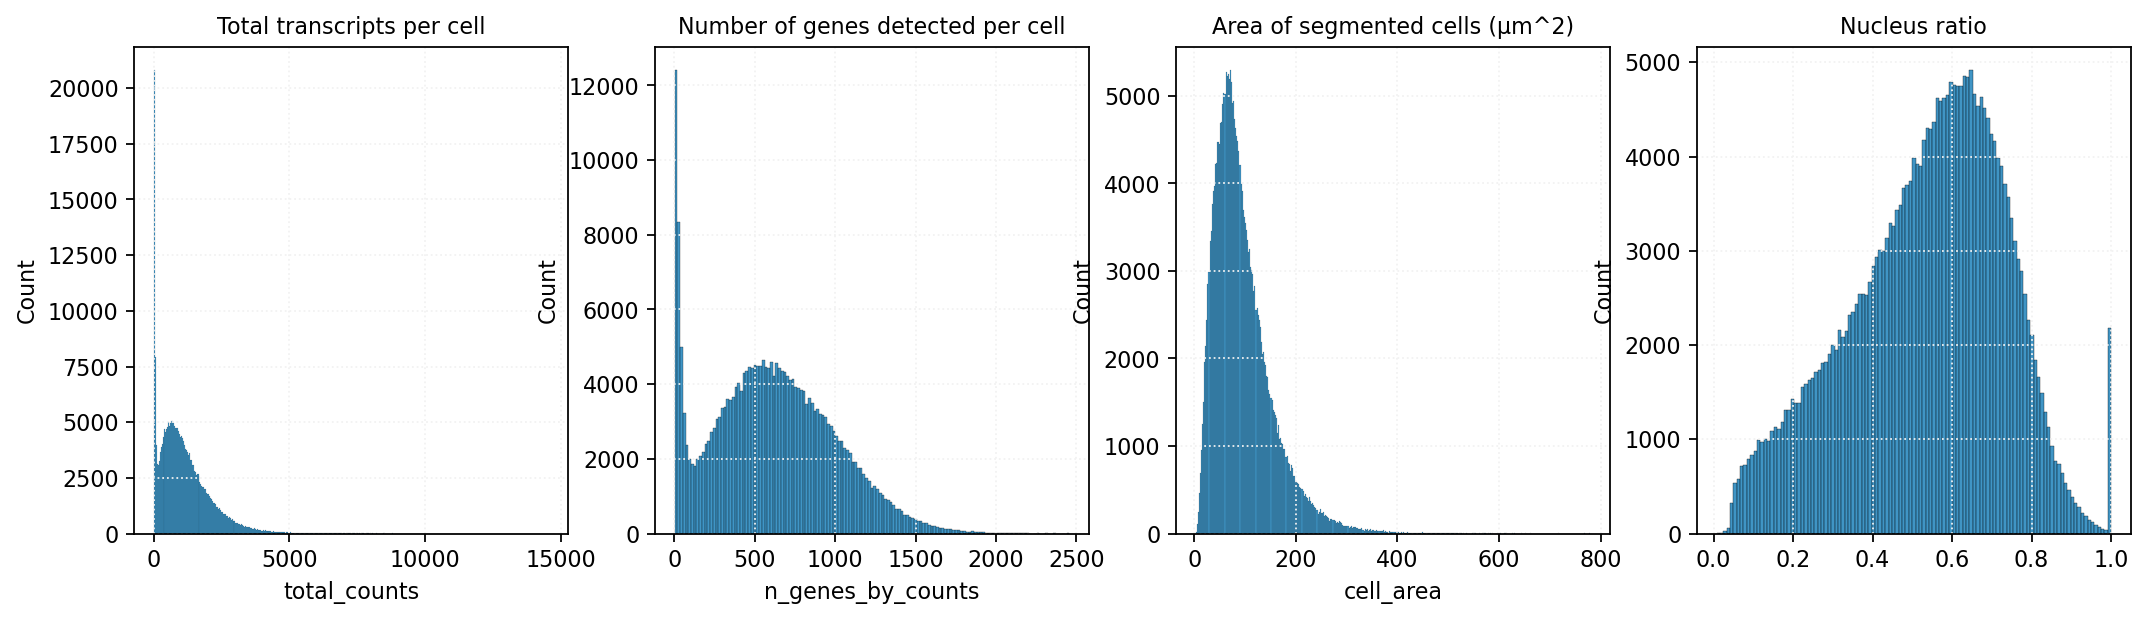

In [78]:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))

axs[0].set_title("Total transcripts per cell")
sns.histplot(
    adata.obs["total_counts"],
    kde=False,
    ax=axs[0],
)

axs[1].set_title("Number of genes detected per cell")
sns.histplot(
    adata.obs["n_genes_by_counts"],
    kde=False,
    ax=axs[1],
)


axs[2].set_title("Area of segmented cells (μm^2)")
sns.histplot(
    adata.obs["cell_area"],
    kde=False,
    ax=axs[2],
)

axs[3].set_title("Nucleus ratio")
sns.histplot(
    adata.obs["nucleus_area"] / adata.obs["cell_area"],
    kde=False,
    ax=axs[3],
)
OUTPUTS["qc-metrics_hist"] = fig

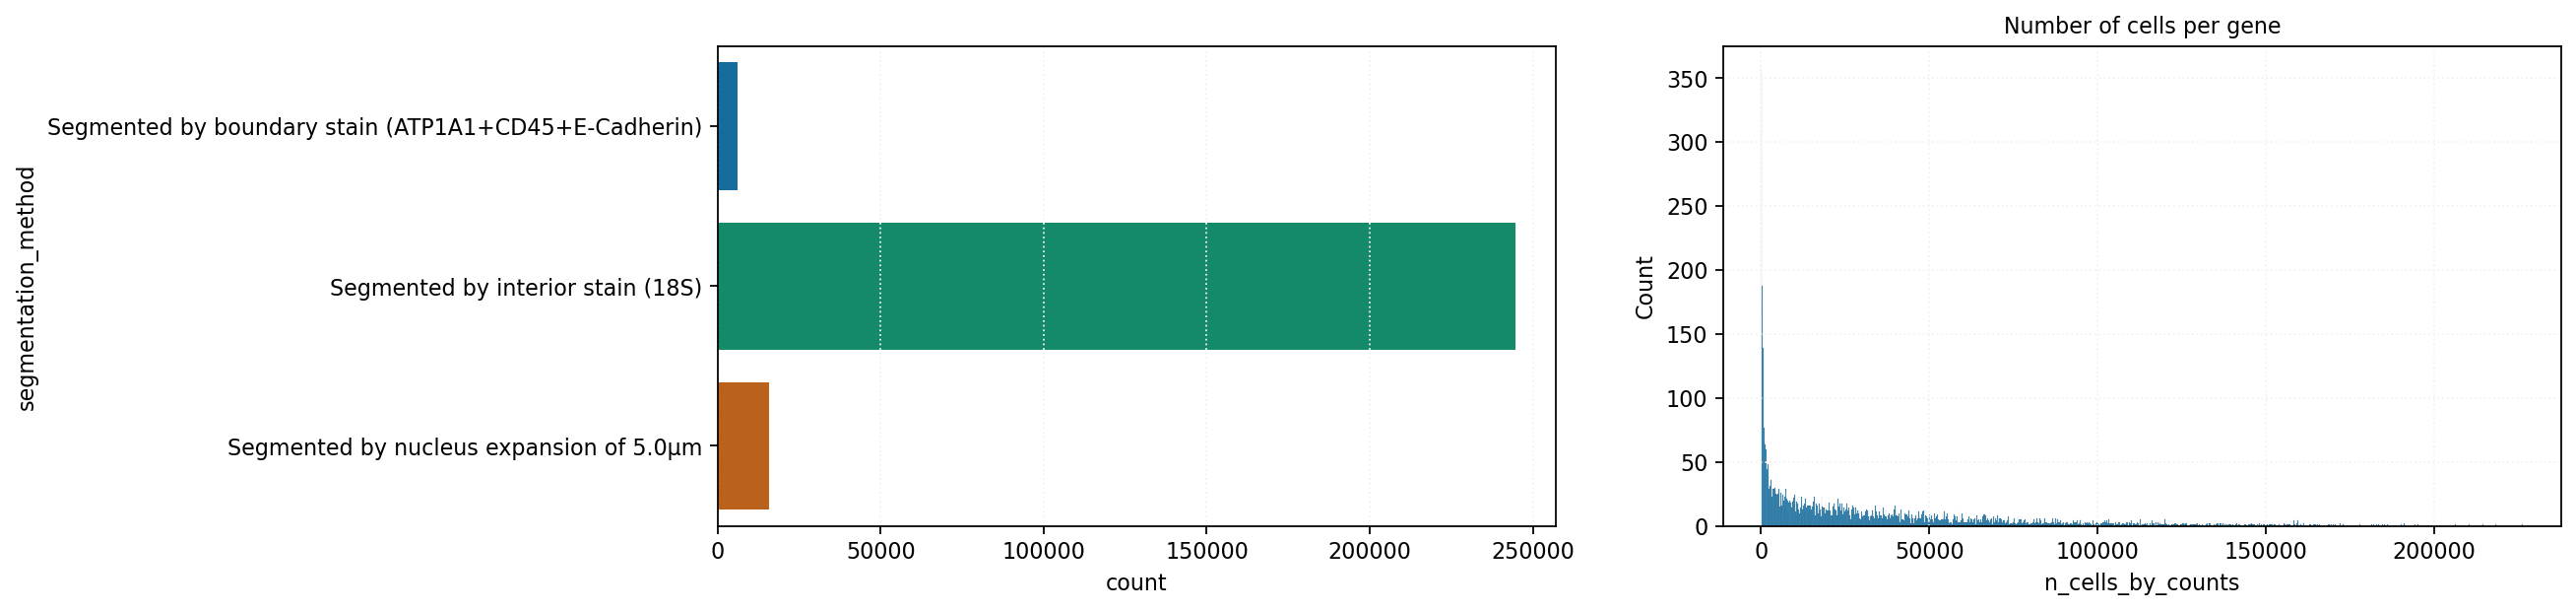

In [81]:
# Plot distribution of total cells per gene per segmentation method
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.countplot(
    data=adata.obs, y="segmentation_method", hue="segmentation_method", ax=axs[0]
)
axs[1].set_title("Number of cells per gene")
sns.histplot(
    adata.var["n_cells_by_counts"], kde=False, bins=1000, ax=axs[1]
);  # fmt: skip
OUTPUTS["segmentation_hist"] = fig

#### Necrosis

Low * content might indicate necrotic tissue, therefore, we would like to remove
at the dip in a biomodal distribution.

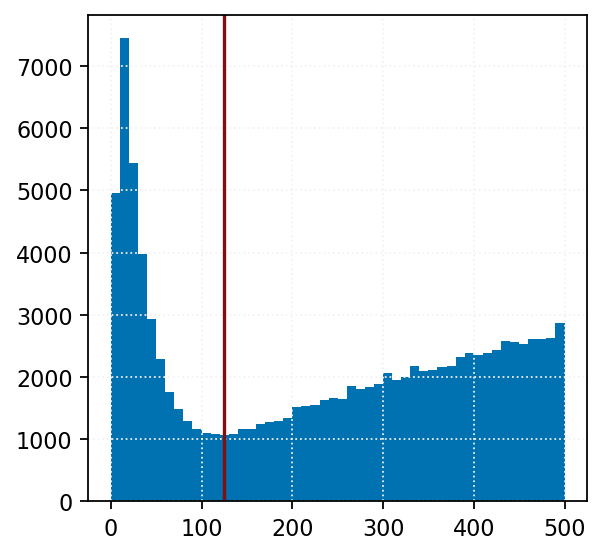

In [120]:
# Change the upper bound of the range to where you think makes sense.
ax = plt.hist(adata.obs["n_genes_by_counts"], bins=50, range=(0, 500))
fig = plt.gcf()
n, bins = ax[0], ax[1]
min_index = n.argmin()
necrosis_cutoff_genes = (bins[min_index] + bins[min_index + 1]) / 2
plt.axvline(x=necrosis_cutoff_genes, color="#800f0f");  # fmt: skip
OUTPUTS["necrosis-cutoff_n-genes-by-counts"] = fig

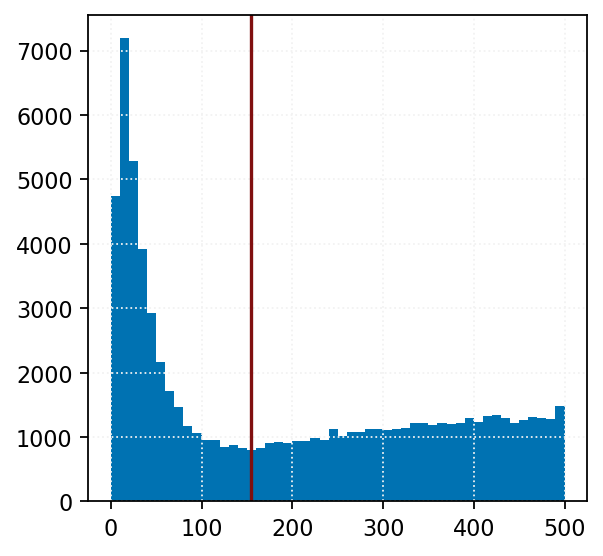

In [122]:
ax = plt.hist(adata.obs["total_counts"], bins=50, range=(0, 500))
fig = plt.gcf()
n, bins = ax[0], ax[1]
min_index = n.argmin()
necrosis_cutoff_transcripts = (bins[min_index] + bins[min_index + 1]) / 2
plt.axvline(x=necrosis_cutoff_transcripts, color="#800f0f");  # fmt: skip
OUTPUTS["necrosis-cutoff_total-counts"] = fig

In [38]:
adata.obs["necrotic"] = (adata.obs["n_genes_by_counts"] < necrosis_cutoff_genes) | (
    adata.obs["total_counts"] < necrosis_cutoff_transcripts
)

Check the spatial distribution of the tissue label as necrotic.

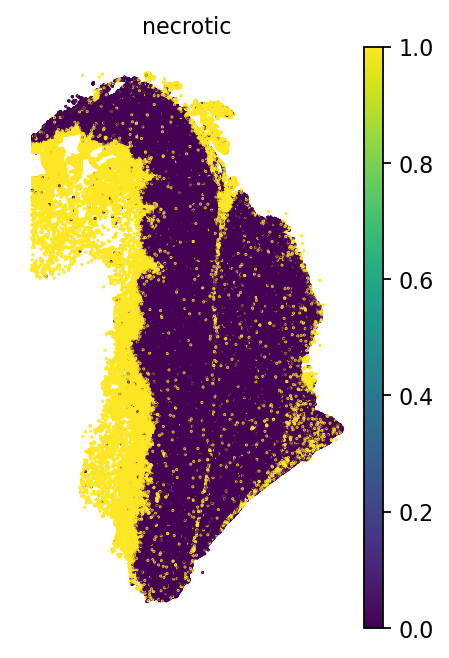

In [187]:
OUTPUTS["necrosis_spatial"] = sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,
    color="necrotic",
    return_ax=True,
).get_figure()

#### Filter cells

In [40]:
sc.pp.filter_cells(adata, min_genes=3)

In [41]:
sc.pp.filter_genes(adata, min_counts=10)

In [42]:
sc.pp.filter_genes(adata, min_cells=10)

In [43]:
adata

AnnData object with n_obs × n_vars = 266605 × 5001
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'genomic_control_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'nucleus_count', 'segmentation_method', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_10_genes', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_150_genes', 'necrotic', 'n_genes'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_counts', 'n_cells'
    obsm: 'spatial'

#### Processing counts

In [44]:
adata.layers["counts"] = adata.X.copy()

In [47]:
sc.pp.normalize_total(adata, target_sum=10000, inplace=True)

In [48]:
sc.pp.log1p(adata)

#### Clustering

This usually is given from a reference (suspension data) but we can identify larger structructures, including the necrotic region, by clustering here.

In [49]:
sc.pp.pca(adata)

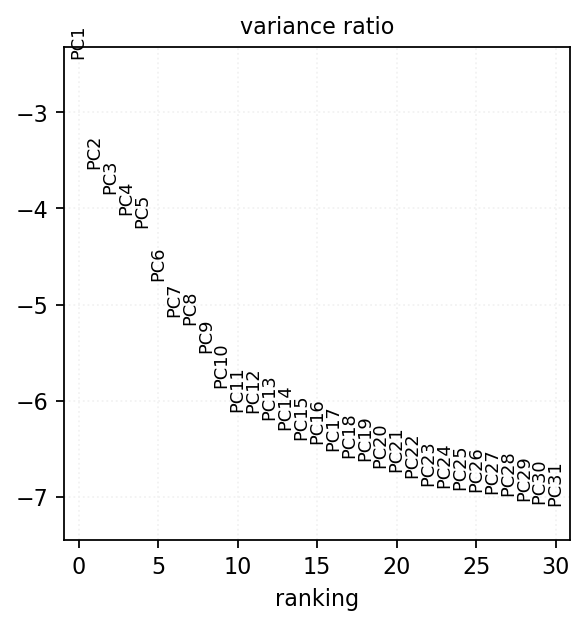

In [50]:
sc.pl.pca_variance_ratio(adata, log=True)

In [51]:
%%time
sc.pp.neighbors(adata, n_pcs=25)

/lustre/scratch126/cellgen/team298/cs59/mambaforge/envs/squidpy_v1.4.1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [52]:
%%time
sc.tl.leiden(adata, resolution = 0.5)

CPU times: user 1min 57s, sys: 3.7 s, total: 2min 1s
Wall time: 2min 1s


In [53]:
%%time
sc.tl.umap(adata)

CPU times: user 2min 50s, sys: 3.7 s, total: 2min 54s
Wall time: 2min 55s


#### Composition

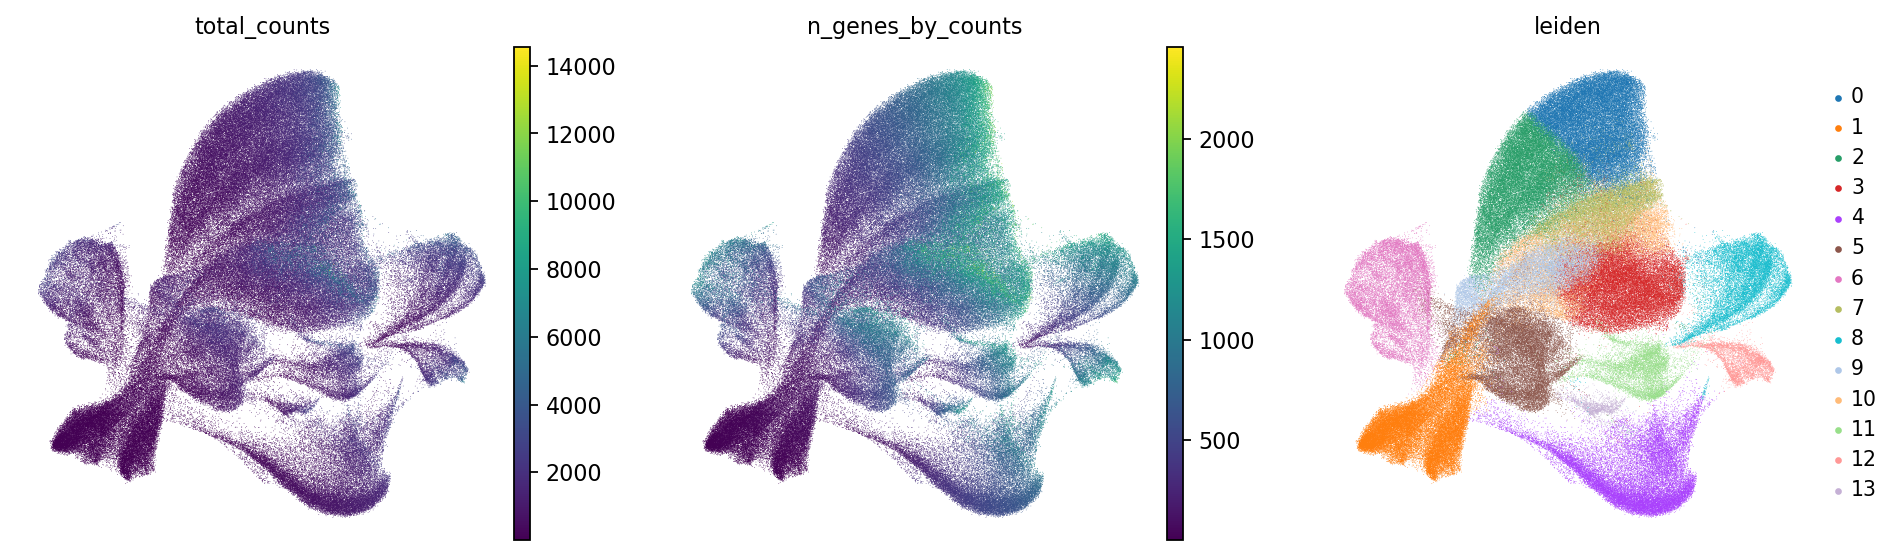

In [93]:
OUTPUTS["leiden_umap"] = sc.pl.umap(
    adata,
    color=[
        "total_counts",
        "n_genes_by_counts",
        "leiden",
    ],
    return_fig=True,
)

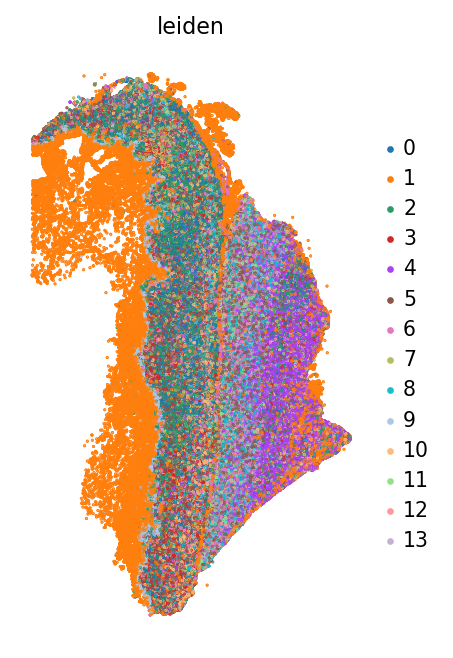

In [188]:
OUTPUTS["leiden_spatial"] = sq.pl.spatial_scatter(
    adata,
    library_id="spatial",
    shape=None,  # fails if not None
    color="leiden",
    return_ax=True,
).get_figure()

Checking which is enriched for necrotic tissue.

[2024-11-05 12:21:57] INFO [category.py:223] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[2024-11-05 12:21:57] INFO [category.py:223] Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


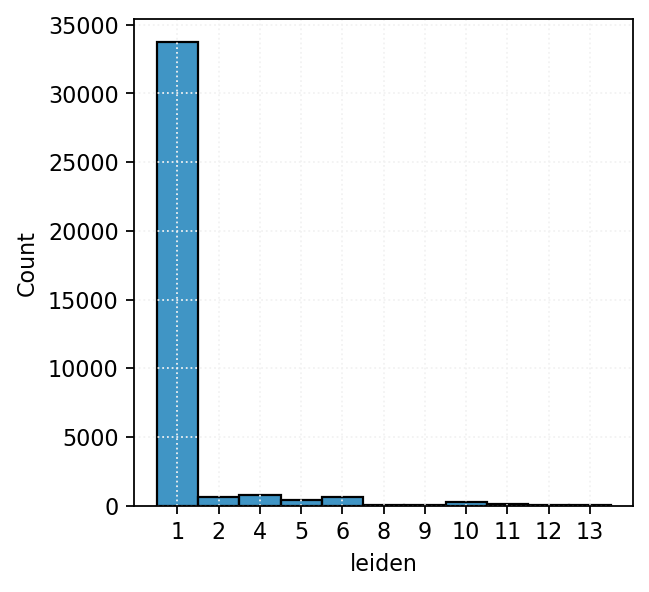

In [194]:
fig, axs = plt.subplots()
sns.histplot(adata[adata.obs["necrotic"] == True].obs["leiden"], ax=axs)
OUTPUTS["necrosis_leiden_hist"] = fig

#### Markers

We just need to make sure we are not discarding important cells in the necrotic
region.

In [72]:
%%time
sc.tl.rank_genes_groups(adata, 'leiden', method = 'wilcoxon', n_genes = 100, use_raw = False)

CPU times: user 2min, sys: 24.7 s, total: 2min 25s
Wall time: 2min 31s


In [96]:
OUTPUTS["features_leiden_dotplot_top5"] = sc.pl.rank_genes_groups_dotplot(
    adata, groupby="leiden", standard_scale="var", n_genes=5, return_fig=True
)

### [Conclusions](#menu) <a class="anchor" id="bullet5"></a>

In [ ]:
temp = list(OUTPUTS.keys())
temp

In [ ]:
for i in temp:
    if len(re.findall(r"params|colours", i)) > 0:
        del OUTPUTS[i]

In [ ]:
OUTPUTS.keys()

dict_keys(['varx_vary_varcol_varsize_plot-type_features_params', 'colours_dots_colourblind_lines-colon', 'qc-metrics_hist', 'segmentation_hist', 'necrosis-cutoff_n-genes-by-counts', 'necrosis-cutoff_total-counts', 'necrosis_spatial', 'leiden_umap', 'leiden_spatial', 'necrosis_leiden_hist', 'features_leiden_dotplot_top5'])

### [Save](#menu) <a class="anchor" id="bullet6"></a>

In [75]:
for i in [output_figs, output_resu]:
    if not os.path.isdir(i):
        os.makedirs(i)

In [199]:
pflag = " \033[1;32m√\033[0m"
cflag = 0
for filename, item in OUTPUTS.items():
    # output_resu vs output_figs
    # if not "necrosis_leiden_hist" in filename:
    #     continue
    if isinstance(item, (pd.DataFrame, dict)):
        fname = os.path.join(output_resu, f"{str(cflag).zfill(2)}_{filename}")
    else:
        fname = os.path.join(output_figs, f"{str(cflag).zfill(2)}_{filename}")
    print("Storing", type(item), "\n", fname, end="")
    eflag = " \033[1;31mX\033[0m"
    if not os.path.isdir(os.path.dirname(fname)):
        os.makedirs(os.path.dirname(fname))
    # file type # ------------------------------------------
    if isinstance(item, (mplfig.Figure, tuple)):
        (item[0] if isinstance(item, tuple) else item).savefig(f"{fname}.png")
        plt.close()
        eflag = pflag
    elif isinstance(item, pd.DataFrame):
        item.to_csv(f"{fname}.csv")
        eflag = pflag
    elif isinstance(item, dict):
        with open(f"{fname}.pickle", "wb") as handle:
            pickle.dump(item, handle, protocol=pickle.HIGHEST_PROTOCOL)
        eflag = pflag
    elif item is not None:
        item.savefig(f"{fname}.png")
        plt.close()
        eflag = pflag
    print(f"{eflag}")
    cflag += 1

Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/00_varx_vary_varcol_varsize_plot-type_features_params √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/01_colours_dots_colourblind_lines-colon √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/02_qc-metrics_hist √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/03_segmentation_hist √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/04_necrosis-cutoff_n-genes-by-counts √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/05_necrosis-cutoff_total-counts √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/06_necrosis_spatial √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/07_leiden_umap √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/08_leiden_spatial √
Storing <class 'matplotlib.figure.Figure'> 
 ./figures/qc_example_1/09_necrosis_leiden_hist √
Storing <class 'scan

Done.